# Project Milestone 4: Preliminary Results

## Imports 

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing, svm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import mutual_info_classif, SelectKBest, chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

## Feature extraction 

Load the data.

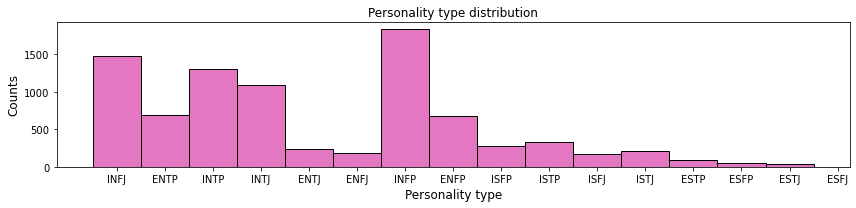

In [2]:
data = pd.read_csv('./data/mbti_1.csv')

fig, ax = plt.subplots(tight_layout=True)
ax = data['type'].hist(figsize=(12, 3), bins=np.arange(16)-0.5, 
                       ec='k', color='tab:pink', grid=False, ax=ax)
ax.set_xlabel('Personality type', fontsize='large')
ax.set_ylabel('Counts', fontsize='large')
ax.set_title('Personality type distribution', fontsize='large')
plt.savefig('figures/personality_type_dist.png', dpi=300)

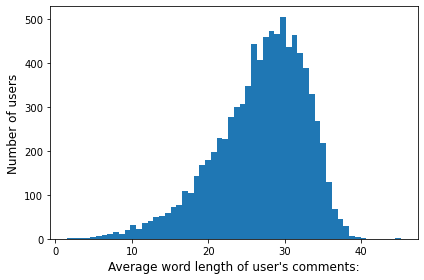

In [3]:
mean_comment_lengths = []
for i in range(data.shape[0]):
    comments = data.loc[i, 'posts'].split('|||')
    mean_coment_length = np.mean([len(comment.split(' ')) for comment in comments])
    mean_comment_lengths.append(mean_coment_length)
    
fig, ax = plt.subplots(tight_layout=True)
ax.hist(mean_comment_lengths, bins='auto')
ax.set_ylabel('Number of users', fontsize='large')
ax.set_xlabel("Average word length of user's comments:", fontsize='large')
plt.savefig('figures/comment_length_dist.png', dpi=300)

Change to integer feature labels.

In [4]:
data = data.replace({c: i for i, c in enumerate(pd.unique(data['type']))})
data.head()

,type,posts
0,0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,1,'I'm finding the lack of me in these posts ver...
2,2,'Good one _____ https://www.youtube.com/wat...
3,3,"'Dear INTP, I enjoyed our conversation the o..."
4,4,'You're fired.|||That's another silly misconce...


Create feature matrix of raw word frequencies.

In [5]:
vectorizer = CountVectorizer(input='content')
X = vectorizer.fit_transform(list(data['posts']))
y = data['type'].values

print('n_classes =', X.shape[0])
print('n_features =', X.shape[1])

n_classes = 8675
n_features = 145412


View the most frequent words.

In [6]:
word_freq_list = list(vectorizer.vocabulary_.items())
sorted_word_freq_list = sorted(word_freq_list, key=lambda x: x[1], reverse=True)

sorted_word_freq_list[:10]

[('ﾟﾟ', 145411),
 ('ﾟдﾟщ', 145410),
 ('ﾉﾟ', 145409),
 ('ﾉﾞ', 145408),
 ('ﾉｼ', 145407),
 ('ﾉωﾉ', 145406),
 ('ｗｈｙu3000ｉｓu3000ａｎｙｏｎｅu3000ｓｔｉｌｌu3000ｄｉｓｃｕｓｓｉｎｇu3000ｔｈｉｓ', 145405),
 ('ｖａｐｏｒｗａｖｅ', 145404),
 ('ｔｒｕｍｐu3000ｉｓu3000ａｎu3000ｅｓｔｐ', 145403),
 ('ｓｏ', 145402)]

Split into testing and training.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training samples: {}'.format(len(y_train)))
print('Testing samples: {}'.format(len(y_test)))

Training samples: 6940
Testing samples: 1735


### Feature selection
See https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection. For example, we could use `mutual_info_classif` with `SelectKBest` to keep the $K$ best features according to their mutual information score. Or could do something else for now like PCA.

Select a dimensionality reduction technique below. Run only that section of cells. Then split into testing/training sets before running classification.

#### Mutual Information

In [11]:
m_info_scores = mutual_info_classif(X_train, y_train)
m_info_scores

array([4.63581620e-03, 4.02814192e-03, 5.26090599e-04, ...,
       2.98372438e-16, 2.77634655e-04, 2.94722181e-04])

The mutual info scores are relatively very low. There are only 6 features with a score greater than 0.1, 381 features with a score greater than 0.01, and 19037 features with a score greater than 0.001. The last threshold represents about 13% of the features, so I think that's a good starting point.

In [12]:
k_num = np.count_nonzero(m_info_scores > 0.001)
print(k_num)
X_new = SelectKBest(chi2, k=k_num).fit_transform(X, y)
print(X_new.shape)

19037
(8675, 19037)


#### PCA / Truncated Singular Value Decomp
X matrix is sparse but dense so PCA and SparsePCA does not work, needed to use TruncatedSVD

Found that 500 features explains above 86.7% of the variance. We can easily automate this to find some preferred error rate. 

In [13]:
pca = TruncatedSVD(n_components=500, n_iter=10, random_state=42)
X_new = pca.fit_transform(X, y)
print(X_new.shape)
print(pca.explained_variance_ratio_.sum())

(8675, 500)
0.8670950171056562


Re-split into testing and training after reducing dimensionality.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=42)
print('Training samples: {}'.format(len(y_train)))
print('Testing samples: {}'.format(len(y_test)))

Training samples: 6940
Testing samples: 1735


## Classification

Random guessing.

In [72]:
y_pred = np.random.randint(0, 16, size=y_test.shape)
print('Accuracy = {:.2f}'.format(accuracy_score(y_test, y_pred)))

Accuracy = 0.06


In [73]:
import time
import util

def classifier(Xtr, ytr, Xte, method, args=()):
    if isinstance(method, (sklearn.svm.classes.SVC, 
                           sklearn.tree.DecisionTreeClassifier,
                           )):
        method.fit(Xtr, ytr)
        return method.predict(Xte)
    return method(Xtr, ytr, Xte, *args)

In [74]:
# reference usage with Qi mpp
import classifiers as cfs

# even priors
P = np.ones(16)
P = P*(1.0/16.0)

t0 = time.time()
y_model = classifier(X_train, y_train, X_test, cfs.mpp, (1,P))
t1 = time.time()

acc_classwise, acc_overall = util.accuracy_score(y_test, y_model)
print(f'Overall accuracy = {acc_overall};')
print(f'Classwise accuracy = {acc_classwise};')
print(f'The learning process takes {t1 - t0} seconds.')

Overall accuracy = 0.16311239193083574;
Classwise accuracy = [0.20486111 0.16296296 0.1331058  0.12435233 0.15909091 0.51219512
 0.14594595 0.208      0.11320755 0.1641791  0.11111111 0.09090909
 0.06666667 0.375      0.         0.14285714];
The learning process takes 0.3249330520629883 seconds.


In [ ]:
# reference usage with sklearn svm

clf = svm.SVC(kernel='linear', C=1)
t0 = time.time()
y_model = classifier(X_train, y_train, X_test, clf, ())
t1 = time.time()

acc_classwise, acc_overall = util.accuracy_score(y_test, y_model)
print(f'Overall accuracy = {acc_overall};')
print(f'Classwise accuracy = {acc_classwise};')
print(f'The learning process takes {t1 - t0} seconds.')

In [71]:
# reference usage with sklearn DecisionTreeClassifier 

from sklearn import tree

clf = tree.DecisionTreeClassifier()
t0 = time.time()
y_model = classifier(X_train, y_train, X_test, clf, ())
t1 = time.time()

acc_classwise, acc_overall = util.accuracy_score(y_test, y_model)
print(f'Overall accuracy = {acc_overall};')
print(f'Classwise accuracy = {acc_classwise};')
print(f'The learning process takes {t1 - t0} seconds.')

Overall accuracy = 0.2478386167146974;
Classwise accuracy = [0.34027778 0.22222222 0.29010239 0.24352332 0.02272727 0.
 0.35135135 0.232      0.03773585 0.07462687 0.02222222 0.04545455
 0.         0.         0.         0.        ];
The learning process takes 5.604804992675781 seconds.


Support vector machine (linear kernel).
I assume we'll get better results ith TF-IDF vectors but do we need that for this step?

In [27]:
# clf = svm.LinearSVC()
clf = svm.SVC(kernel='linear', C=1)
clf.fit(X_train, y_train)
y_pred_lin = clf.predict(X_test)

SVM polynomial kernel

In [26]:
clf = svm.SVC(kernel='poly', C=1, gamma='auto')
clf.fit(X_train, y_train)
y_pred_pol = clf.predict(X_test)

## Performance evalutation
I suppose we should use $k$-fold cross validation.

Accuracy and cross validation scores vary across runs.
Comparison of linear and polynmomial kernels may not be valid
for these singular run results.

In [18]:
print('Accuracy = {:.2f}'.format(accuracy_score(y_test, y_pred_lin)))

Accuracy = 0.55


In [ ]:
print('Accuracy = {:.2f}'.format(accuracy_score(y_test, y_pred_pol)))

$k$-fold cross validation SVM linear kernel

In [25]:
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.55 (+/- 0.02)


$k$-fold cross validation ploynomial kernel

In [24]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.47 (+/- 0.04)
